# setup and imports

In [94]:
import fnmatch
import matplotlib.pyplot as plt
from ipywidgets import interactive
import numpy as np
import os
import glob
import pickle
import platform
import matplotlib.patches as mpatches

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [95]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 26 rats in the data folder


In [96]:
rat_markers = {}
sequence = {}
params = {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}
trackTimeToLeftBin, trackTimeToRightBin = {}, {}
instantSpeedLeftBin, instantSpeedRightBin = {}, {}

TM1_pfPOS = [16.1, 97.3]
TM2_pfPOS = [17.2, 98.1]
TM1_virtualBoundary = [34.55, 80]  # in behav_params, should read_params(root, animal, session, "boundaryLeft")/11 ; read_params(root, animal, session, "boundaryRight")/11, but no change across sessions
TM2_virtualBoundary = [34.55, 80]


pfPOS = {'RatF00':TM1_pfPOS, 'RatF01':TM1_pfPOS, 'RatF02':TM1_pfPOS, 'RatF03':TM1_pfPOS, 
         'RatM00':TM2_pfPOS, 'RatM01':TM2_pfPOS, 'RatM02':TM2_pfPOS, 'RatM03':TM2_pfPOS}
virtualBoundary = {'RatF00':TM1_virtualBoundary, 'RatF01':TM1_virtualBoundary, 'RatF02':TM1_virtualBoundary, 'RatF03':TM1_virtualBoundary, 
                   'RatM00':TM2_virtualBoundary, 'RatM01':TM2_virtualBoundary, 'RatM02':TM2_virtualBoundary, 'RatM03':TM2_virtualBoundary}


# define colors for each rat
palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2),
           'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2),
           'RatF32': (0.8, 0.2, 0.2), 'RatF33': (0.8, 0.2, 0.2),
           'RatM31': (0.13, 0.55, 0.13), 'RatM32': (0.2, 0.8, 0.2), 
           'RatF42': (0.8, 0.2, 0.2), 'RatM40': (0.13, 0.55, 0.13), 'RatM43': (0.2, 0.8, 0.2)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal'
               }

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

# define list of rats to be analyzed

# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatF02':
        rat_markers[animal][0] = 'dodgerblue'

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        # get the preprocessed data from the pickle file
        biglesion = True if 'L' in session else False
        
        params[animal, session]     = get_from_pickle(root, animal, session, name="params.p")
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackPos.p")
        trackTimeToLeftBin[animal, session], trackTimeToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackTime.p")
        instantSpeedLeftBin[animal, session],instantSpeedRightBin[animal, session]= get_from_pickle(root, animal, session, name="trackSpeed.p")      

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43


# A, Raw speed profile for 1 animal in all conditions, first block of last AM session
# B, Rescaled speed profile

In [97]:
from VIGOR_Functions import compute_median_trajectory

# utility plot functions
def plot_speed_profile(posdataRight, timedataRight, xylim,
                color, xyLabels=["", ""], ax=None):
    '''Plot speed profile for each run
    Args:
        posdataRight: list of lists, position data for each run
        timedataRight: list of lists, time data for each run
        xylim: list of 4 scalars, x and y limits for the plot
        color: list of 2 colors, color of the plot
        xyLabels: list of 2 strings, x and y labels for the plot
        ax: matplotlib axis object, if None, create a new figure and axis
    Returns:
        ax: matplotlib axis object
    '''
    if ax is None:
        ax = plt.gca()

    for pos, time in zip(posdataRight, timedataRight):
        t = np.subtract(time, time[0])
        abs_speed = [abs(_) for _ in pos]
        ax.plot(t, abs_speed, color=color, linewidth=0.1, alpha=0.5)

    ax.set_xlabel(xyLabels[0])
    ax.set_ylabel(xyLabels[1])
    ax.set_xlim([xylim[0], xylim[1]])
    ax.set_ylim([xylim[2], xylim[3]])
    return ax


# remove treadmill speed from speed profile
def removeTMspeed(datap, datas, TMspeed, 
                    pfPOS, virtualBoundary, k=.5):
    """remove treadmill speed between platform and virtual boundary
        for speed profiles in which the treadmill is on
    Args:
        datap: list of lists, position data for each run
        datas: list of lists, speed data for each run
        TMspeed: scalar, treadmill speed
        pfPOS: list of 2 scalars, platform position
        virtualBoundary: list of 2 scalars, virtual boundary position
        k: scalar, steepness of the function
    Returns:
        output: list of lists, corrected speed data for each run
    """
    def _correctTM(x, k=k, mu1=20, mu2=85, amp=20):
        """
        (approximation of the Heaviside function)
        Args:
            x: scalar, position 
            k: scalar, steepness of the function 
            mu1: scalar, start location, end of platform
            mu2: scalar, end location, virutal boundary location
            amp: scalar, height of the  function, treadmill speed
        Returns:
            p: scalar, f(x)
        """  
        LEFT = 1/(1+np.exp(-k*(x-mu1)))
        RIGHT = 1/(1+np.exp(k*(x-mu2)))
        return LEFT * RIGHT * amp

    output = copy.deepcopy(datas)

    if np.all([isinstance(dat, float) for dat in datap]):  # if only one run is available
        for j, (pos, speed) in enumerate(zip(datap, datas)):  # loop through time points in a run
            if datap[0] < datap[-1]:  # going to right, treadmill effect when not on left platform until right virtual boundary
                output[j] -= _correctTM(pos, k=k, mu1=pfPOS[0], mu2=virtualBoundary[1], amp=TMspeed)
            elif datap[0] > datap[-1]:  # going to left, treadmill effect when not on right platform until left virtual boundary
                output[j] -= _correctTM(pos, k=k, mu1=virtualBoundary[0], mu2=pfPOS[1], amp=TMspeed)
    else:
        for i, (positionarray, speedarray) in enumerate(zip(datap, datas)):  # loop through individual runs
            for j, (pos, speed) in enumerate(zip(positionarray, speedarray)):  # loop through time points in a run
                if positionarray[0] < positionarray[-1]:  # going to right, treadmill effect when not on left platform until right virtual boundary
                    output[i][j] -= _correctTM(pos, k=k, mu1=pfPOS[0], mu2=virtualBoundary[1], amp=TMspeed)
                elif positionarray[0] > positionarray[-1]:  # going to left, treadmill effect when not on right platform until left virtual boundary
                    output[i][j] -= _correctTM(pos, k=k, mu1=virtualBoundary[0], mu2=pfPOS[1], amp=TMspeed)
    return output


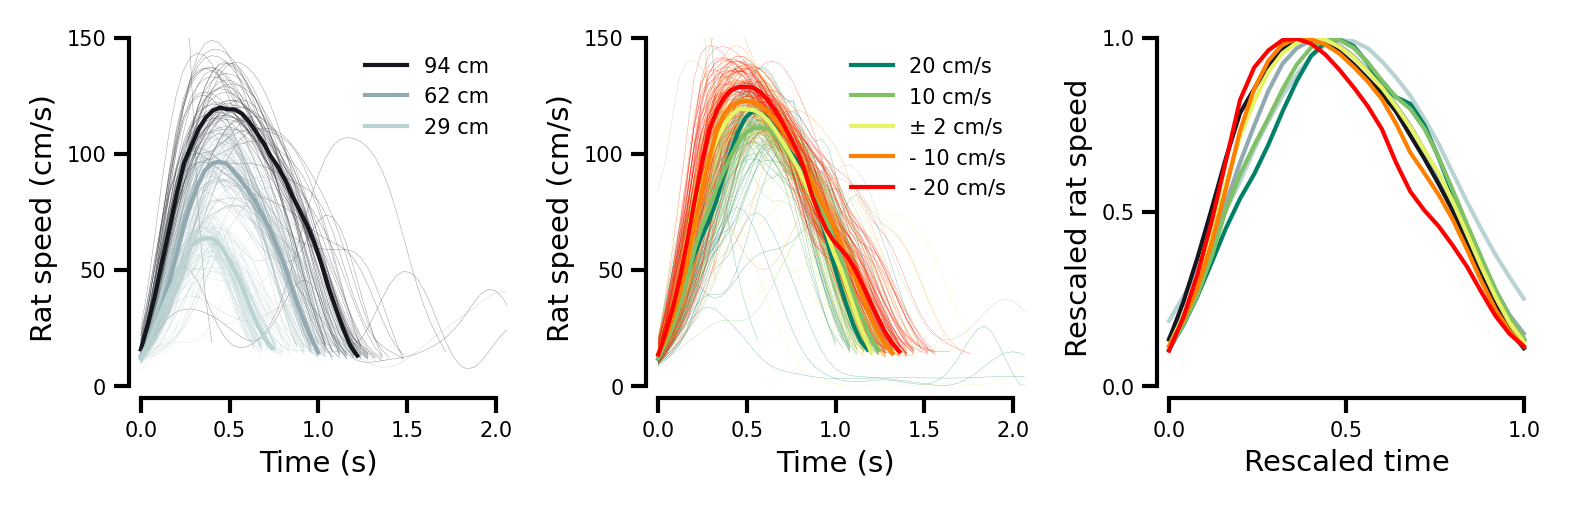

In [98]:
# A, plot speed profiles for each experimental condition
# B, same but rescaled by average speed and movement time
condition_color_code = {'29 cm': plt.cm.get_cmap('bone')(0.8), '62 cm': plt.cm.get_cmap('bone')(0.65), '94 cm': plt.cm.get_cmap('bone')(.1),
                        '20 cm/s': plt.cm.get_cmap('summer')(0), '10 cm/s': plt.cm.get_cmap('summer')(.5), '± 2 cm/s': plt.cm.get_cmap('summer')(.9),
                        '- 10 cm/s': plt.cm.get_cmap('autumn')(.5), '- 20 cm/s': plt.cm.get_cmap('autumn')(0)}


def Figure3A(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # example session
    animal = 'RatF01'  # sample animal
    index_session_example = -2  #last AM session
    index_block_example = 0 # first block

    for condition, conditionname in zip([dist120, dist90, dist60], ['94 cm', '62 cm', '29 cm']):
        session = matchsession(animal, condition)[index_session_example]
        example_time = trackTimeToRightBin[animal, session][index_block_example]

        # keep treadmill speed for dist sessions
        if session in dist60+dist90+dist120:
            example_speed = instantSpeedRightBin[animal, session][index_block_example]
        
        # remove treadmill speed for TM sessions
        elif session in TM20+TM10+TM2+TMrev10+TMrev20:
            p = XtrackRunToRightBin[animal, session][index_block_example]
            s = instantSpeedRightBin[animal, session][index_block_example]
            t = trackTimeToRightBin[animal, session][index_block_example]
            tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
            example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])

        # plot individual speed profiles
        plot_speed_profile(example_speed, example_time, 
                    xylim = [0, 2, 0, 150], color=condition_color_code[conditionname], 
                    xyLabels=["Time (s)", "Rat speed (cm/s)"], ax=ax) 

        # plot median trajectory
        ax.plot(*compute_median_trajectory(example_speed, example_time), 
                    color=condition_color_code[conditionname], lw=1, alpha=1, zorder = 3, label=conditionname)

        ax.set_yticks([0, 50, 100, 150])
        space_axes(ax)

        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc='best',
                                frameon=False, fontsize=5,
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)




def Figure3Abis(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # example session
    animal = 'RatF01'  # sample animal
    index_session_example = -2  #last AM session
    index_block_example = 0 # first block

    for condition, conditionname in zip([TM20, TM10, TM2, TMrev10, TMrev20], ['20 cm/s', '10 cm/s', '± 2 cm/s', '- 10 cm/s', '- 20 cm/s']):
        session = matchsession(animal, condition)[index_session_example]
        example_time = trackTimeToRightBin[animal, session][index_block_example]

        # keep treadmill speed for dist sessions
        if session in dist60+dist90+dist120:
            example_speed = instantSpeedRightBin[animal, session][index_block_example]
        
        # remove treadmill speed for TM sessions
        elif session in TM20+TM10+TM2+TMrev10+TMrev20:
            p = XtrackRunToRightBin[animal, session][index_block_example]
            s = instantSpeedRightBin[animal, session][index_block_example]
            t = trackTimeToRightBin[animal, session][index_block_example]
            tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
            example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])

        # plot individual speed profiles
        plot_speed_profile(example_speed, example_time, 
                    xylim = [0, 2, 0, 150], color=condition_color_code[conditionname],
                    xyLabels=["Time (s)", "Rat speed (cm/s)"], ax=ax) 

        # plot median trajectory
        ax.plot(*compute_median_trajectory(example_speed, example_time), 
                    color=condition_color_code[conditionname], lw=1, alpha=1, zorder = 3, label=conditionname)

        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc='best',
                                frameon=False, fontsize=5,
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
        ax.set_yticks([0, 50, 100, 150])
        space_axes(ax)
        # ax.set_yticks([])
        # ax.spines['left'].set_visible(False)



def Figure3B(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # example session
    animal = 'RatF01'  # sample animal
    index_session_example = -2  #last AM session
    index_block_example = 0 # first block

    for condition, conditionname in zip([dist60, dist90, dist120, TM20, TM10, TM2, TMrev10, TMrev20], 
    ['29 cm', '62 cm', '94 cm', '20 cm/s', '10 cm/s', '± 2 cm/s', '- 10 cm/s', '- 20 cm/s']):
        session = matchsession(animal, condition)[index_session_example]
        example_time = trackTimeToRightBin[animal, session][index_block_example]

        # keep treadmill speed for dist sessions
        if session in dist60+dist90+dist120:
            example_speed = instantSpeedRightBin[animal, session][index_block_example]
        
        # remove treadmill speed for TM sessions
        elif session in TM20+TM10+TM2+TMrev10+TMrev20:
            p = XtrackRunToRightBin[animal, session][index_block_example]
            s = instantSpeedRightBin[animal, session][index_block_example]
            t = trackTimeToRightBin[animal, session][index_block_example]
            tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
            example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])

        #rescale by average speed and movement time
        rescaled_time = copy.deepcopy(example_time)
        for i in range(len(example_time)):
            rescaled_time[i] = np.array(example_time[i])/(example_time[i][-1]-example_time[i][0])

        rescaled_speed = copy.deepcopy(example_speed)
        for i in range(len(example_speed)):
            # rescaled_speed[i] = np.array(example_speed[i])/np.nanmean(example_speed[i])
            rescaled_speed[i] = np.array(example_speed[i])/np.nanmax(example_speed[i])

        # plot median trajectory
        ax.plot(*compute_median_trajectory(rescaled_speed, rescaled_time), 
                    color=condition_color_code[conditionname], lw=1, alpha=1, zorder = 3, label=conditionname)

    ax.set_xlabel("Rescaled time")
    ax.set_ylabel("Rescaled rat speed")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([0.0, 0.5, 1.0])
    ax.set_yticklabels([0.0, 0.5, 1.0])
    space_axes(ax)
    
fig, axs = plt.subplots(1, 3, figsize=(cm2inch(13), cm2inch(4)), dpi=300)
Figure3A(axs[0])
Figure3Abis(axs[1])
Figure3B(axs[2])

# C, Speed profiles annotations

Notation for a speed profile:  
- $t$: time  
- $T$: crossing time  
- $v(t)$: speed  
- $V_{max}$: maximum speed  
- $v_{belt}$: speed of the treadmill belt  

We can rescale the speed profile for each experimental condition:  
- $\tilde{t} = \frac{t}{T}$, rescaled time between 0-1  
- $\tilde{v}(\tilde{t}) = \frac{v(t)}{V_{max}}$, rescaled speed between 0-1  

We notice that the speed profile is the same for each experimental condition (universal speed profile $\tilde{v}(\tilde{t})$), scaled in time and Vmax.  

The speed of the rat is:  
$v(t) = v_{belt} + V_{max} \tilde{v}(\tilde{t})$ &emsp;  with $\tilde{v}(\tilde{t})$ universal speed function  

When the rat travels a distance $D$ in time $T$ on a belt of speed $v_{belt}$, the position $x$ of the rat is: 
$x(T) = D = v_{belt}*T + V_{max}T V_0 $   &emsp; with $V_0 = \int_0^1 \tilde{v}(\tilde{t})d\tilde{t}$ a constant  

This gives the following expression for $V_{max}$:  
$V_{max} = \frac{D-v_{belt} T}{V_0 T}$  

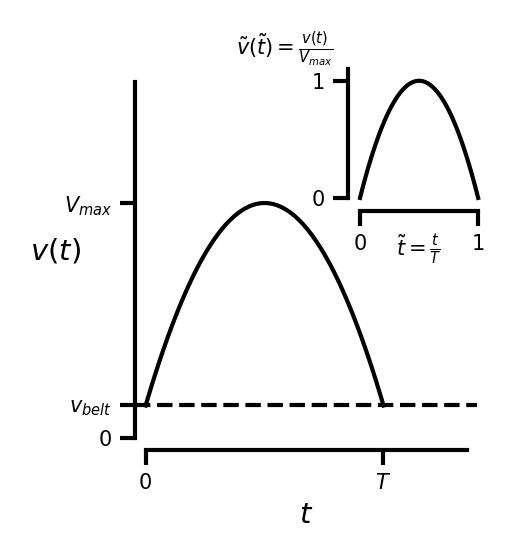

In [99]:
def Figure3C(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # vbelt line
    VBELT = 0.2
    ax.axhline(VBELT, color='k', linestyle='--', lw=1)
    # ax.axhline(0, color='k', linestyle='--', lw=1)

    # parabola for speed profile
    def _simple_parabola(x, a, b, c):
        return a * x**2 + b * x + c

    y = _simple_parabola(np.linspace(0, 1, 100), -5, 5, VBELT)
    ax.plot(np.linspace(0, 1, 100), y, color='k', lw=1)
    VMAX = np.max(y)
    VMOY = np.mean(y)
    # ax.plot([0, .5], [VMAX, VMAX], color='k', linestyle='--', lw=1)


    # labels and lims
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$v(t)$', rotation=0, loc='center')
    ax.set_xlim([0, 1.35])
    ax.set_ylim([0, 2.2])
    space_axes(ax)

    ax.set_xticks([0, 1])
    ax.set_xticklabels([0, r'$T$'])
    ax.set_yticks([0, VBELT, VMAX])
    ax.set_yticklabels([0, r'$v_{belt}$', r'$V_{max}$'])


def Figure3Cbis(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # vbelt line
    VBELT = 0

    # parabola for speed profile
    def _simple_parabola(x, a, b, c):
        return a * x**2 + b * x + c

    y = _simple_parabola(np.linspace(0, 1, 100), -5, 5, VBELT)
    ax.plot(np.linspace(0, 1, 100), y/np.max(y), color='k', lw=1)
    VMAX = np.max(y)
    VMOY = np.mean(y)
    # ax.plot([0, .5], [1, 1], color='k', linestyle='--', lw=1)

    # labels and lims
    ax.set_xlabel(r'$\tilde{t} = \frac{t}{T}$', labelpad=-5, fontsize=5)
    ax.set_ylabel(r'$\tilde{v}(\tilde{t}) = \frac{v(t)}{V_{max}}$', labelpad=-5, fontsize=5, rotation=0, loc='top')

    ax.set_xticks([0, 1])
    ax.set_xticklabels([0, 1])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1])


    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.1)
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure3C(ax=ax)

l, b, h, w = .7, .7, .3, 0.3
ax1 = fig.add_axes([l, b, w, h])
Figure3Cbis(ax=ax1)

## Our model
In our model we assume that the total crossing cost is linear combination of an effort-related term and a time-related term:  

### Effort related term - Velocity cost
We assume that the effort-related cost $C_v$ is proportional to the kinetic energy (i.e., moving fast costs more energy). This cost is modulated by an effort sensitivity parameter, $\alpha$. High values of $\alpha$ correspond to a high effort sensitivity (i.e. the effort is perceived as larger). The cost $C_v$ of doing a movement of duration $T$ at speed $v$ on belt of speed $ v_{belt}$ is:  

$C_v = \alpha \int_0^T (v-v_{belt})²dt$  
&emsp;&ensp; $= \alpha V_{max}^2 T V_1$ &emsp; with $V_1 = \int_0^1 \tilde{v}²(\tilde{t})d\tilde{t}$  

Replacing $V_{max}$ yields:  
$C_v = \tilde{\alpha} [\frac{D^2}{T}-2 D v_{belt} + v_{belt}^2 T]$  &emsp;with $\tilde{\alpha} = \frac{\alpha V_1}{V_0^2}$ a constant  


### Time related cost - Time cost  
We assume that a cost linked to time increases as movement time $T$ increases.  
$C_T = T^{n}$  
For simplicity $n$ is fixed to either $1$ or $3$.

#### In our model, the utility $U$ of getting a reward $R$ is therefore: $U = R - C_v - C_T$   
&emsp;  

## Capture rate  
'''utility vs cost'''  
In the Capture Rate it is assumed that the Utility of getting a reward $R$ is : $U_{CR}=\frac{R - C_v}{C_T}$  



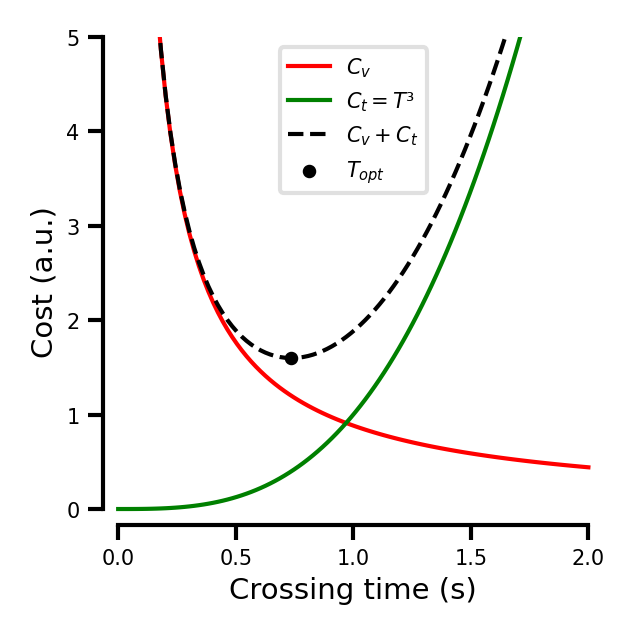

In [100]:
# effort cost for a movement of duration T, distance D, with a belt speed of vbelt
def effort_cost(T, D=1, alpha=1, vbelt=0, power_effort=2):
    np.seterr(divide='ignore')
    vmax = (D - vbelt * T) / (T)
    return alpha * T * (vmax ** power_effort)

# time cost for a movement of duration T
def time_cost(T, beta=1, power_time=3):
    return beta*T ** power_time

def Topt(D, vbelt, alpha):
    det = alpha**2 * vbelt**4 + 12 * alpha * D**2
    toptsquared = (np.sqrt(det) - (alpha * vbelt**2)) / 6
    return np.sqrt(toptsquared)


def Figure3E_(ax=None, D=.94, vbelt=0, alpha=1, beta=1, power_effort=2, power_time=3):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    t = np.linspace(0, 2, 100)
    ax.plot(t, effort_cost(t, D, alpha, vbelt, power_effort), label=r'$C_v$', c='r')
    ax.plot(t, time_cost(t, beta, power_time), label=r'$C_t=T³$', c='g')
    # ax.plot(t, time_cost(t, beta, 1), label=r'$C_t=T¹$', c='g', alpha=.5, linestyle='--')
    ax.plot(t, effort_cost(t, D, alpha, vbelt, power_effort) + time_cost(t, beta, power_time), label=r'$C_v + C_t$', c='k', ls='--')
    # ax.plot(t, effort_cost(t, D, alpha, vbelt, power_effort) + time_cost(t, beta, 1), label=r'$C_v + C_t$', c='k', alpha=.5, linestyle='--')

    ax.scatter(Topt(D, vbelt, alpha), effort_cost(Topt(D, vbelt, alpha), D, alpha, vbelt, power_effort) + time_cost(Topt(D, vbelt, alpha), beta, power_time),
            color='k', s=5, label=r'$T_{opt}$')

    # ax.plot(t[np.nanargmin(effort_cost(t, D, alpha, vbelt, power_effort) + time_cost(t, beta, power_time))], 
    #         np.nanmin(effort_cost(t, D, alpha, vbelt, power_effort) + time_cost(t, beta, power_time)),
    #         'o', color='k', markersize=3, label=r'$T_{opt}$')

    ax.set_xlabel('Crossing time (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.legend()

    ax.set_ylim(0, 5)
    ax.set_xlim(0, 2)
    space_axes(ax)

Figure3E_()

# 3D Utility as a function of movement time for different rewards in our model and in CR



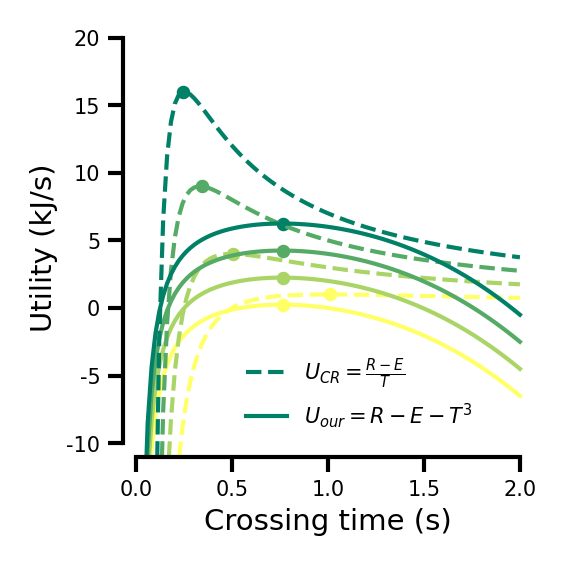

In [101]:


# CR utility for a movement of duration T, distance D, with a belt speed 
# of vbelt, and a reward of R
# U = (R - effort_cost) / T
def utility_CR(R, T, D, VBELT):
    np.seterr(divide='ignore')
    C_v = effort_cost(T, D, alpha=1, vbelt=VBELT, power_effort=2)
    C_t = time_cost(T, power_time=1)
    return (R - C_v) / C_t

# our model utility for a movement of duration T, distance D, with a belt speed 
# of vbelt, and a reward of R
# U = R - effort_cost - T^power
def utility_our_model(R, T, D, VBELT):
    C_v = effort_cost(T, D, alpha=1, vbelt=VBELT, power_effort=2)
    C_t = time_cost(T, power_time=3)
    return R - C_v - C_t


def Figure3D(ax=None, power=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    T = np.linspace(0.0, 2, 100)
    # for R in [2, 4, 6, 8]:  # reward size


    rewards = [2, 4, 6, 8]
    cmapCR = plt.get_cmap('summer_r', len(rewards))
    cmap = plt.get_cmap('summer_r', len(rewards))
    for idx, R in enumerate(rewards):
        # plot max((R-E)/T) vs max R-E -T
        # line is utility, dot is Topt
        ax.plot(T, utility_CR(R, T, 1, 0), ls='--', c=cmapCR(idx))
        ax.scatter(T[np.nanargmax(utility_CR(R, T, 1, 0))], 
                    np.nanmax(utility_CR(R, T, 1, 0)), color=cmapCR(idx), s=5)
        
        ax.plot(T, utility_our_model(R, T, 1, 0), ls='-', c=cmap(idx))
        ax.scatter(T[np.nanargmax(utility_our_model(R, T, 1, 0))], 
                     np.nanmax(utility_our_model(R, T, 1, 0)), color=cmap(idx), s=5)
                     
    # labels
    ax.set_xlabel("Crossing time (s)")
    ax.set_ylabel("Utility (kJ/s)")
    ax.set_xlim([0, 2])
    ax.set_xticks([0, 0.5, 1, 1.5, 2])
    ax.set_ylim([-10, 20])
    space_axes(ax)

    # legend
    # dummy plot for legend
    ax.plot([-100, -101], ls='--', c=cmapCR(4), label=r'$U_{CR} = \frac{R - E}{T}$')
    ax.plot([-100, -101], c=cmap(4), label=r'$U_{our} = R - E - T^{' + str(power) + '}$')

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='lower right', bbox_to_anchor=(0.9, 0.02), 
                                frameon=False, fontsize=5, markerscale=1, 
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4.5), cm2inch(4.5)))

Figure3D(ax, power=3)

# change in D

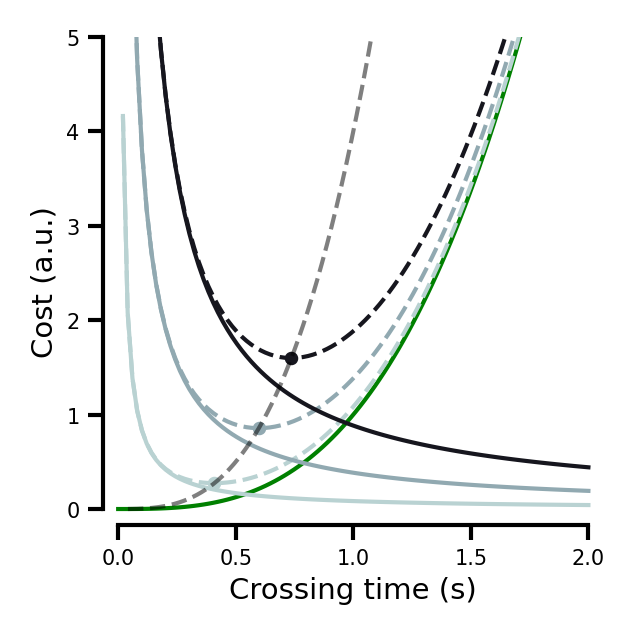

In [102]:

def Figure3G_(ax=None, D=.94, vbelt=0, alpha=1, beta=1, power_effort=2, power_time=3):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    t = np.linspace(0, 2, 100)
    ax.plot(t, time_cost(t, beta, power_time), c='g')

    for d, cond in zip([0.29, 0.62, 0.94], ['29 cm', '62 cm', '94 cm']):
        ax.plot(t, effort_cost(t, d, alpha, vbelt, power_effort), c=condition_color_code[cond], label=r'$C_v(d=$'+cond+r'$)$')
        ax.plot(t, effort_cost(t, d, alpha, vbelt, power_effort) + time_cost(t, beta, power_time), c=condition_color_code[cond], ls='--')

        ax.scatter(Topt(d, vbelt, alpha), 
                   effort_cost(Topt(d, vbelt, alpha), d, alpha, vbelt, power_effort) + time_cost(Topt(d, vbelt, alpha), beta, power_time),
                   color=condition_color_code[cond], s=5)
    
    _x = []
    _y = []
    for d in np.linspace(0, 3, 1000):
        _x.append(Topt(d, vbelt, alpha))
        _y.append(effort_cost(Topt(d, vbelt, alpha), d, alpha, vbelt, power_effort) + time_cost(Topt(d, vbelt, alpha), beta, power_time))
    ax.plot(_x, _y, c='k', lw=1, label='Optimal', ls='--', alpha=.5)


    ax.set_xlabel('Crossing time (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.set_ylim(0, 5)
    ax.set_xlim(0, 2)
    space_axes(ax)

Figure3G_()

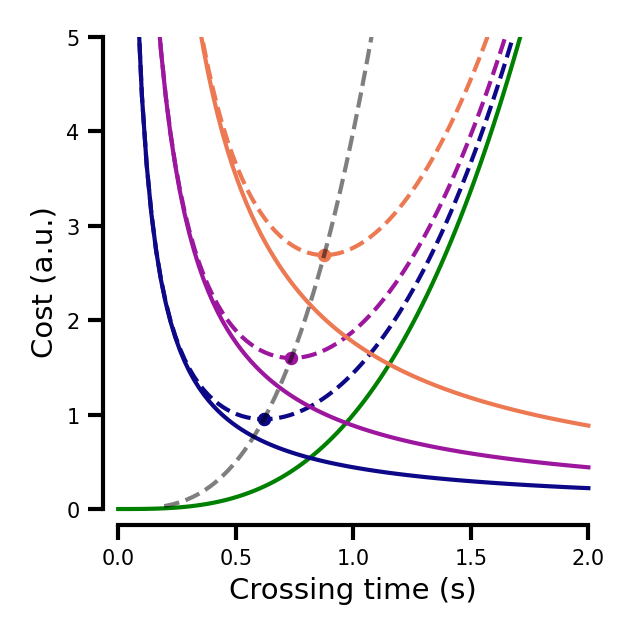

In [103]:

def Figure3H_(ax=None, D=.94, vbelt=0, alpha=1, beta=1, power_effort=2, power_time=3):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    t = np.linspace(0, 2, 100)
    ax.plot(t, time_cost(t, beta, power_time), c='g')

    alphas = [0.5, 1, 2]
    cmap = plt.cm.get_cmap('plasma')

    for idx, alpha in enumerate(alphas):
        ax.plot(t, effort_cost(t, D, alpha, vbelt, power_effort), c=cmap(idx/len(alphas)), label=r'$C_v(\alpha=$'+str(alpha)+r'$)$')
        ax.plot(t, effort_cost(t, D, alpha, vbelt, power_effort) + time_cost(t, beta, power_time), c=cmap(idx/len(alphas)), ls='--')

        ax.scatter(Topt(D, vbelt, alpha), 
                   effort_cost(Topt(D, vbelt, alpha), D, alpha, vbelt, power_effort) + time_cost(Topt(D, vbelt, alpha), beta, power_time),
                   color=cmap(idx/len(alphas)), s=5)

    _x = []
    _y = []

    for alpha in np.linspace(0, 5, 1000):
        _x.append(Topt(D, vbelt, alpha))
        _y.append(effort_cost(Topt(D, vbelt, alpha), D, alpha, vbelt, power_effort) + time_cost(Topt(D, vbelt, alpha), beta, power_time))
    ax.plot(_x, _y, c='k', lw=1, label='Optimal', ls='--', alpha=.5)

    ax.set_xlabel('Crossing time (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.set_ylim(0, 5)
    ax.set_xlim(0, 2)
    space_axes(ax)


Figure3H_()

# Optimal crossing time in our model
Total cost for a crossing is minimized when $\frac{C_v+C_T}{dT} = 0$  

We have:  

$\frac{dC_v}{dT} = \tilde{\alpha} [\frac{-D^2}{T^2} + v_{belt}^2]$  

and  

$\frac{dC_T}{dT} = nT^{n-1}$  

Therefore:  
$\frac{C_v+C_T}{dT} = \tilde{\alpha} [\frac{-D^2}{T^2} + v_{belt}^2] + nT^{n-1} = 0$  

Optimal crossing time $T_{opt}$ for a movement of distance $D$, effort sensitivity $\alpha$ on a belt of speed $v_{belt}$ is:  
- for $n=1$:  
$T_{opt} = \sqrt{\frac{\tilde{\alpha}D²}{1 + \tilde{\alpha}v_{belt}^2}}$

- for $n=3$:  
$T_{opt} = \sqrt{\frac{{-\tilde{\alpha}v_{belt}^2} + \sqrt{\tilde{\alpha}²v_{belt}^4 + 12\tilde{\alpha}D²}}{6}}$  

The rat moves at speed $V_{opt} = \frac{D}{T_{opt}}$.

In [104]:
# compute optimal time for a given distance, belt speed, and reward size
# when time cost is T^1
def T_opt_n1(D, vbelt, alpha):
    Tsq = (alpha * D**2) / (1 + alpha * vbelt**2)
    return np.sqrt(Tsq)

# when time cost is T^3
def T_opt_n3(D, vbelt, alpha):
    det = np.sqrt(alpha**2 * vbelt**4 + 12*alpha*D**2)
    Tsq = ((det - (alpha * vbelt**2)) / 6)
    return np.sqrt(Tsq)

def T_opt_n(D, vbelt, alpha, power_effort, power_time):
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = alpha * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt

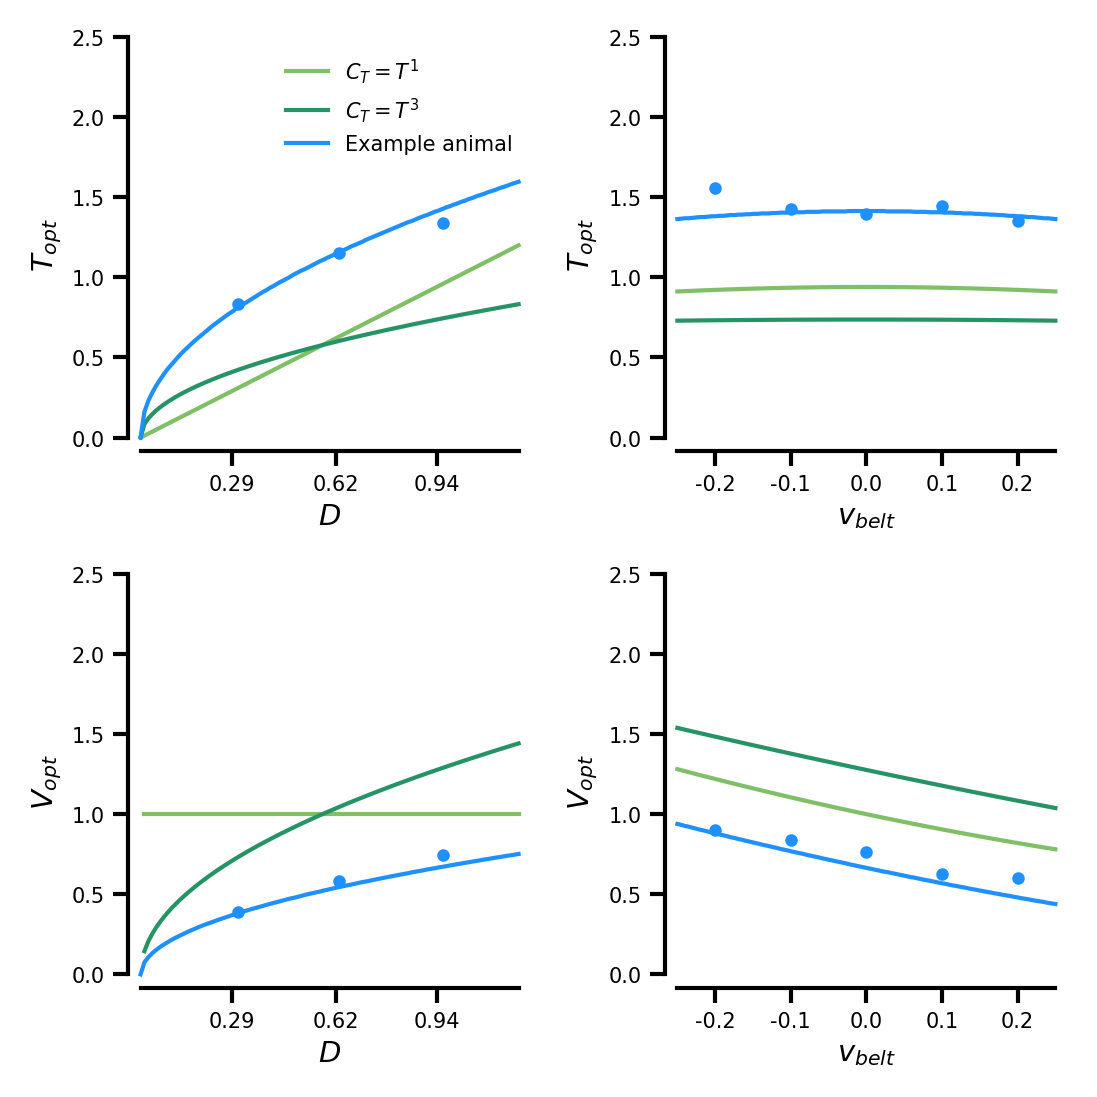

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(cm2inch(9), cm2inch(9)))

# Topt as a function of D
def Figure3E(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)
    ax.plot(D, T_opt_n1(D, Vbelt_cst, ALPHA), label=r'$C_T = T^{1}$', c=plt.get_cmap('summer_r')(0.5))
    ax.plot(D, T_opt_n3(D, Vbelt_cst, ALPHA), label=r'$C_T = T^{3}$', c=plt.get_cmap('summer_r')(0.85))
 
    animal = 'RatF02'
    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
    ax.plot([.31, .63, .96], [mu_0[animal]['60'], mu_0[animal]['90'], mu_0[animal]['120']], color='dodgerblue', marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)
    ax.plot(D, [T_opt_n(d, Vbelt_cst, 13.54, power_effort=2, power_time=3) for d in D], label=f'Example animal', c='dodgerblue')

    ax.set_xlabel(r'$D$')
    ax.set_ylabel(r'$T_{opt}$')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='best',# bbox_to_anchor=(0.01, 0.99), 
                            frameon=False, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


# Topt as a function of Vbelt
def Figure3F(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(-.25, .25, 100)
    ax.plot(VBELT, T_opt_n1(D_cst, VBELT, ALPHA), label=r'$C_T = T^{1}$', c=plt.get_cmap('summer_r')(0.5))
    ax.plot(VBELT, T_opt_n3(D_cst, VBELT, ALPHA), label=r'$C_T = T^{3}$', c=plt.get_cmap('summer_r')(0.85))

    animal = 'RatF02'
    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
    ax.plot([-.2, -.1, 0, .1, .2], [mu_0[animal]['rev20'], mu_0[animal]['rev10'], mu_0[animal]['2'], mu_0[animal]['10'], mu_0[animal]['20']], color='dodgerblue', marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, 13.54, power_effort=2, power_time=3) for vbelt in VBELT], c='dodgerblue')
    
    ax.set_xlabel(r'$v_{belt}$')
    ax.set_ylabel(r'$T_{opt}$')
    ax.set_xlim(-.25, 0.25)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    space_axes(ax)


# Vopt as a function of D
def Figure3I(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)
    ax.plot(D, D/T_opt_n1(D, Vbelt_cst, ALPHA), label=r'$C_T = T^{1}$', c=plt.get_cmap('summer_r')(0.5))
    ax.plot(D, D/T_opt_n3(D, Vbelt_cst, ALPHA), label=r'$C_T = T^{3}$', c=plt.get_cmap('summer_r')(0.85))
    
    animal = 'RatF02'
    speed60, speed90, speed120 = pickle.load(open("picklejar/example_rat_run_speeds_dist.p", "rb"))
    ax.plot([.31, .63, .96], [speed60/100, speed90/100, speed120/100], color='dodgerblue', marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)
    ax.plot(D, D/[T_opt_n(d, Vbelt_cst, 13.54, power_effort=2, power_time=3) for d in D], label=f'Example animal', c='dodgerblue')


    ax.set_xlabel(r'$D$')
    ax.set_ylabel(r'$V_{opt}$')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    space_axes(ax)


# Vopt as a function of Vbelt
def Figure3J(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(-.25, .25, 100)
    ax.plot(VBELT, D_cst/T_opt_n1(D_cst, VBELT, ALPHA) - VBELT, label=r'$C_T = T^{1}$', c=plt.get_cmap('summer_r')(0.5))
    ax.plot(VBELT, D_cst/T_opt_n3(D_cst, VBELT, ALPHA) - VBELT, label=r'$C_T = T^{3}$', c=plt.get_cmap('summer_r')(0.85))

    animal = 'RatF02'
    speedrev20, speedrev10, speed2, speed10, speed20 = pickle.load(open("picklejar/example_rat_run_speeds_tm.p", "rb"))
    ax.plot([-.2, -.1, 0, .1, .2], [speedrev20/100, speedrev10/100, speed2/100, speed10/100, speed20/100], color='dodgerblue', marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)
    ax.plot(VBELT, D_cst / np.array([T_opt_n(D_cst, vbelt, 13.54, power_effort=2, power_time=3) for vbelt in VBELT]) - VBELT, c='dodgerblue')
    
    
    ax.set_xlabel(r'$v_{belt}$')
    ax.set_ylabel(r'$V_{opt}$')
    ax.set_xlim(-.25, 0.25)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    space_axes(ax)


Figure3E(axs[0, 0])
Figure3F(axs[0, 1])
Figure3I(axs[1, 0])
Figure3J(axs[1, 1])

# Optimal crossing time in CR

In CR the utility is maximized when $\frac{U_{CR}}{dT} = 0$  

After simplification we find the optimal $T$ that maximizes $U_{CR}$:  
$T_{opt} = \frac{2\alpha D²}{R+2\alpha Dv_{belt}}$  




<!-- 
$CR = \frac{R-E}{T}$  
with:
$E = \tilde{\alpha} [\frac{d^2}{t_f}-2d v_{belt} + v_{belt}^2 t_f]$  
$T = t_f$

$CR = \frac{R-\tilde{\alpha} [\frac{d^2}{t_f}-2d v_{belt} + v_{belt}^2 t_f]}{t_f}$  
$CR = \frac{RT-\tilde{\alpha} [d - v_{belt} T]²}{T²}$

Max when $CR'=0$  
$CR' = \frac{-RT + 2 \alpha D² - 2 \alpha D v_{belt} T}{T⁴} = 0$  

$CR' = [R + 2 \alpha D v_{belt}]T = 2 \alpha D²$

$T = \frac{2 \alpha D²}{R + 2 \alpha D v_{belt}}$
 -->


In [106]:
def T_opt_CR(D, vbelt, alpha=1, R=1, ):
    np.seterr(divide='ignore', invalid='ignore')
    return (2 * alpha * D**2) / (R + 2 * alpha * D * vbelt)

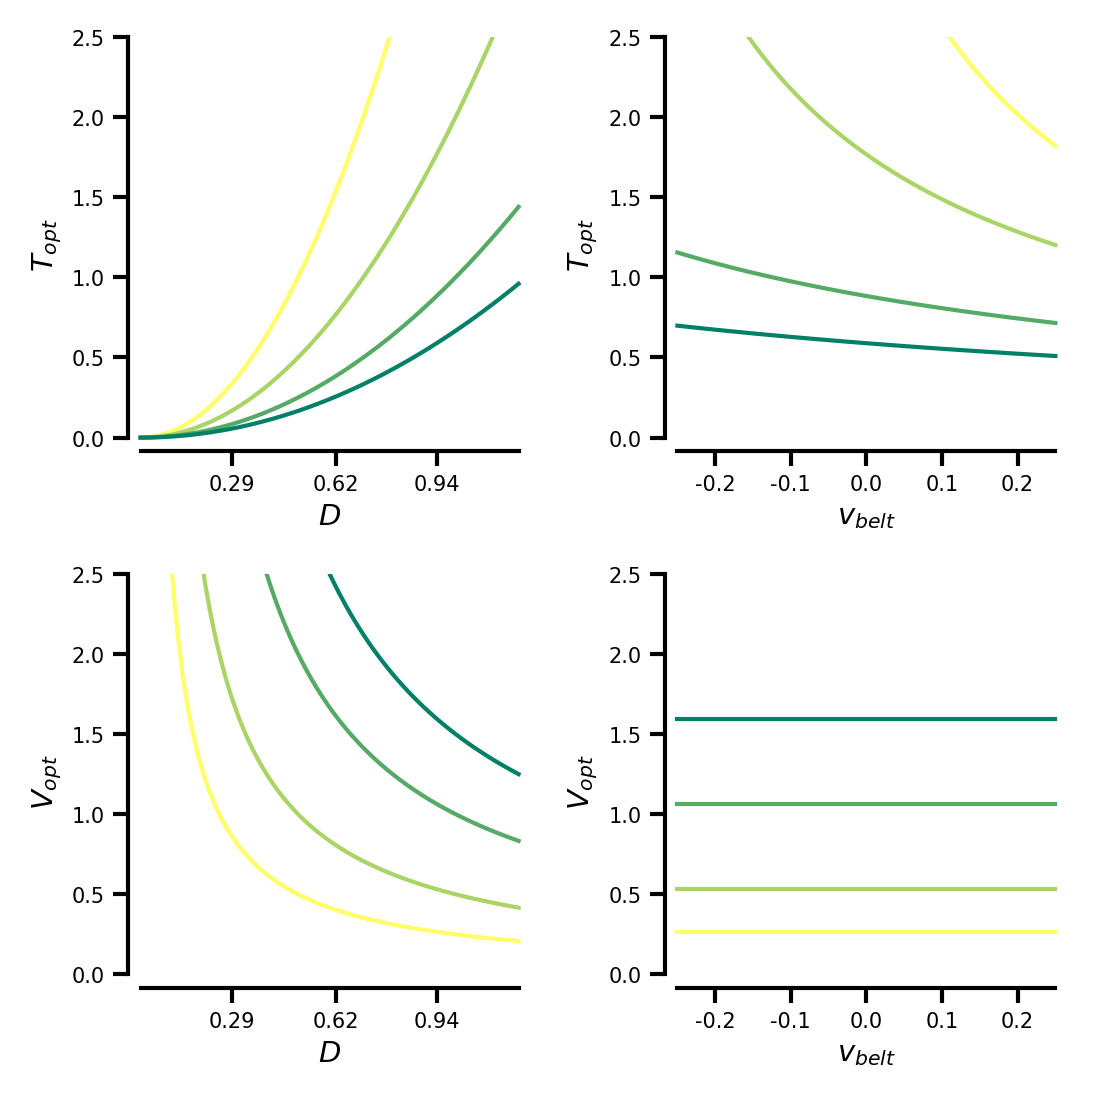

In [107]:
fig, axs = plt.subplots(2, 2, figsize=(cm2inch(9), cm2inch(9)))

# Topt as a function of D
def Figure3G(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1, RWD=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)
    rewards = [0.5, 1, 2, 3]
    cmap = plt.get_cmap('summer_r', len(rewards))
    for idx, r in enumerate(rewards):
        ax.plot(D, T_opt_CR(D, Vbelt_cst, ALPHA, r), color=cmap(idx))
    ax.set_xlabel(r'$D$')
    ax.set_ylabel(r'$T_{opt}$')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    space_axes(ax)


# Topt as a function of Vbelt
def Figure3H(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1, RWD=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(.25, -.25, 100)
    rewards = [0.5, 1, 2, 3]
    cmap = plt.get_cmap('summer_r', len(rewards))
    for idx, r in enumerate(rewards):
        ax.plot(VBELT, T_opt_CR(D_cst, VBELT, ALPHA, r), color=cmap(idx))
    ax.set_xlabel(r'$v_{belt}$')
    ax.set_ylabel(r'$T_{opt}$')
    ax.set_xlim(-.25, 0.25)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    space_axes(ax)

# Vopt as a function of D
def Figure3K(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1, RWD=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)
    rewards = [0.5, 1, 2, 3]
    cmap = plt.get_cmap('summer_r', len(rewards))
    for idx, r in enumerate(rewards):
        ax.plot(D, D/T_opt_CR(D, Vbelt_cst, ALPHA, r), color=cmap(idx))
    ax.set_xlabel(r'$D$')
    ax.set_ylabel(r'$V_{opt}$')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    space_axes(ax)


# Vopt as a function of Vbelt
def Figure3L(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1, RWD=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(.25, -.25, 100)
    rewards = [0.5, 1, 2, 3]
    cmap = plt.get_cmap('summer_r', len(rewards))
    for idx, r in enumerate(rewards):
        ax.plot(VBELT, (D_cst/T_opt_CR(D_cst, VBELT, ALPHA, r))-VBELT, color=cmap(idx))
    ax.set_xlabel(r'$v_{belt}$')
    ax.set_ylabel(r'$V_{opt}$')
    ax.set_xlim(-.25, 0.25)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    space_axes(ax)

Figure3G(axs[0, 0])
Figure3H(axs[0, 1])
Figure3K(axs[1, 0])
Figure3L(axs[1, 1])

# figure

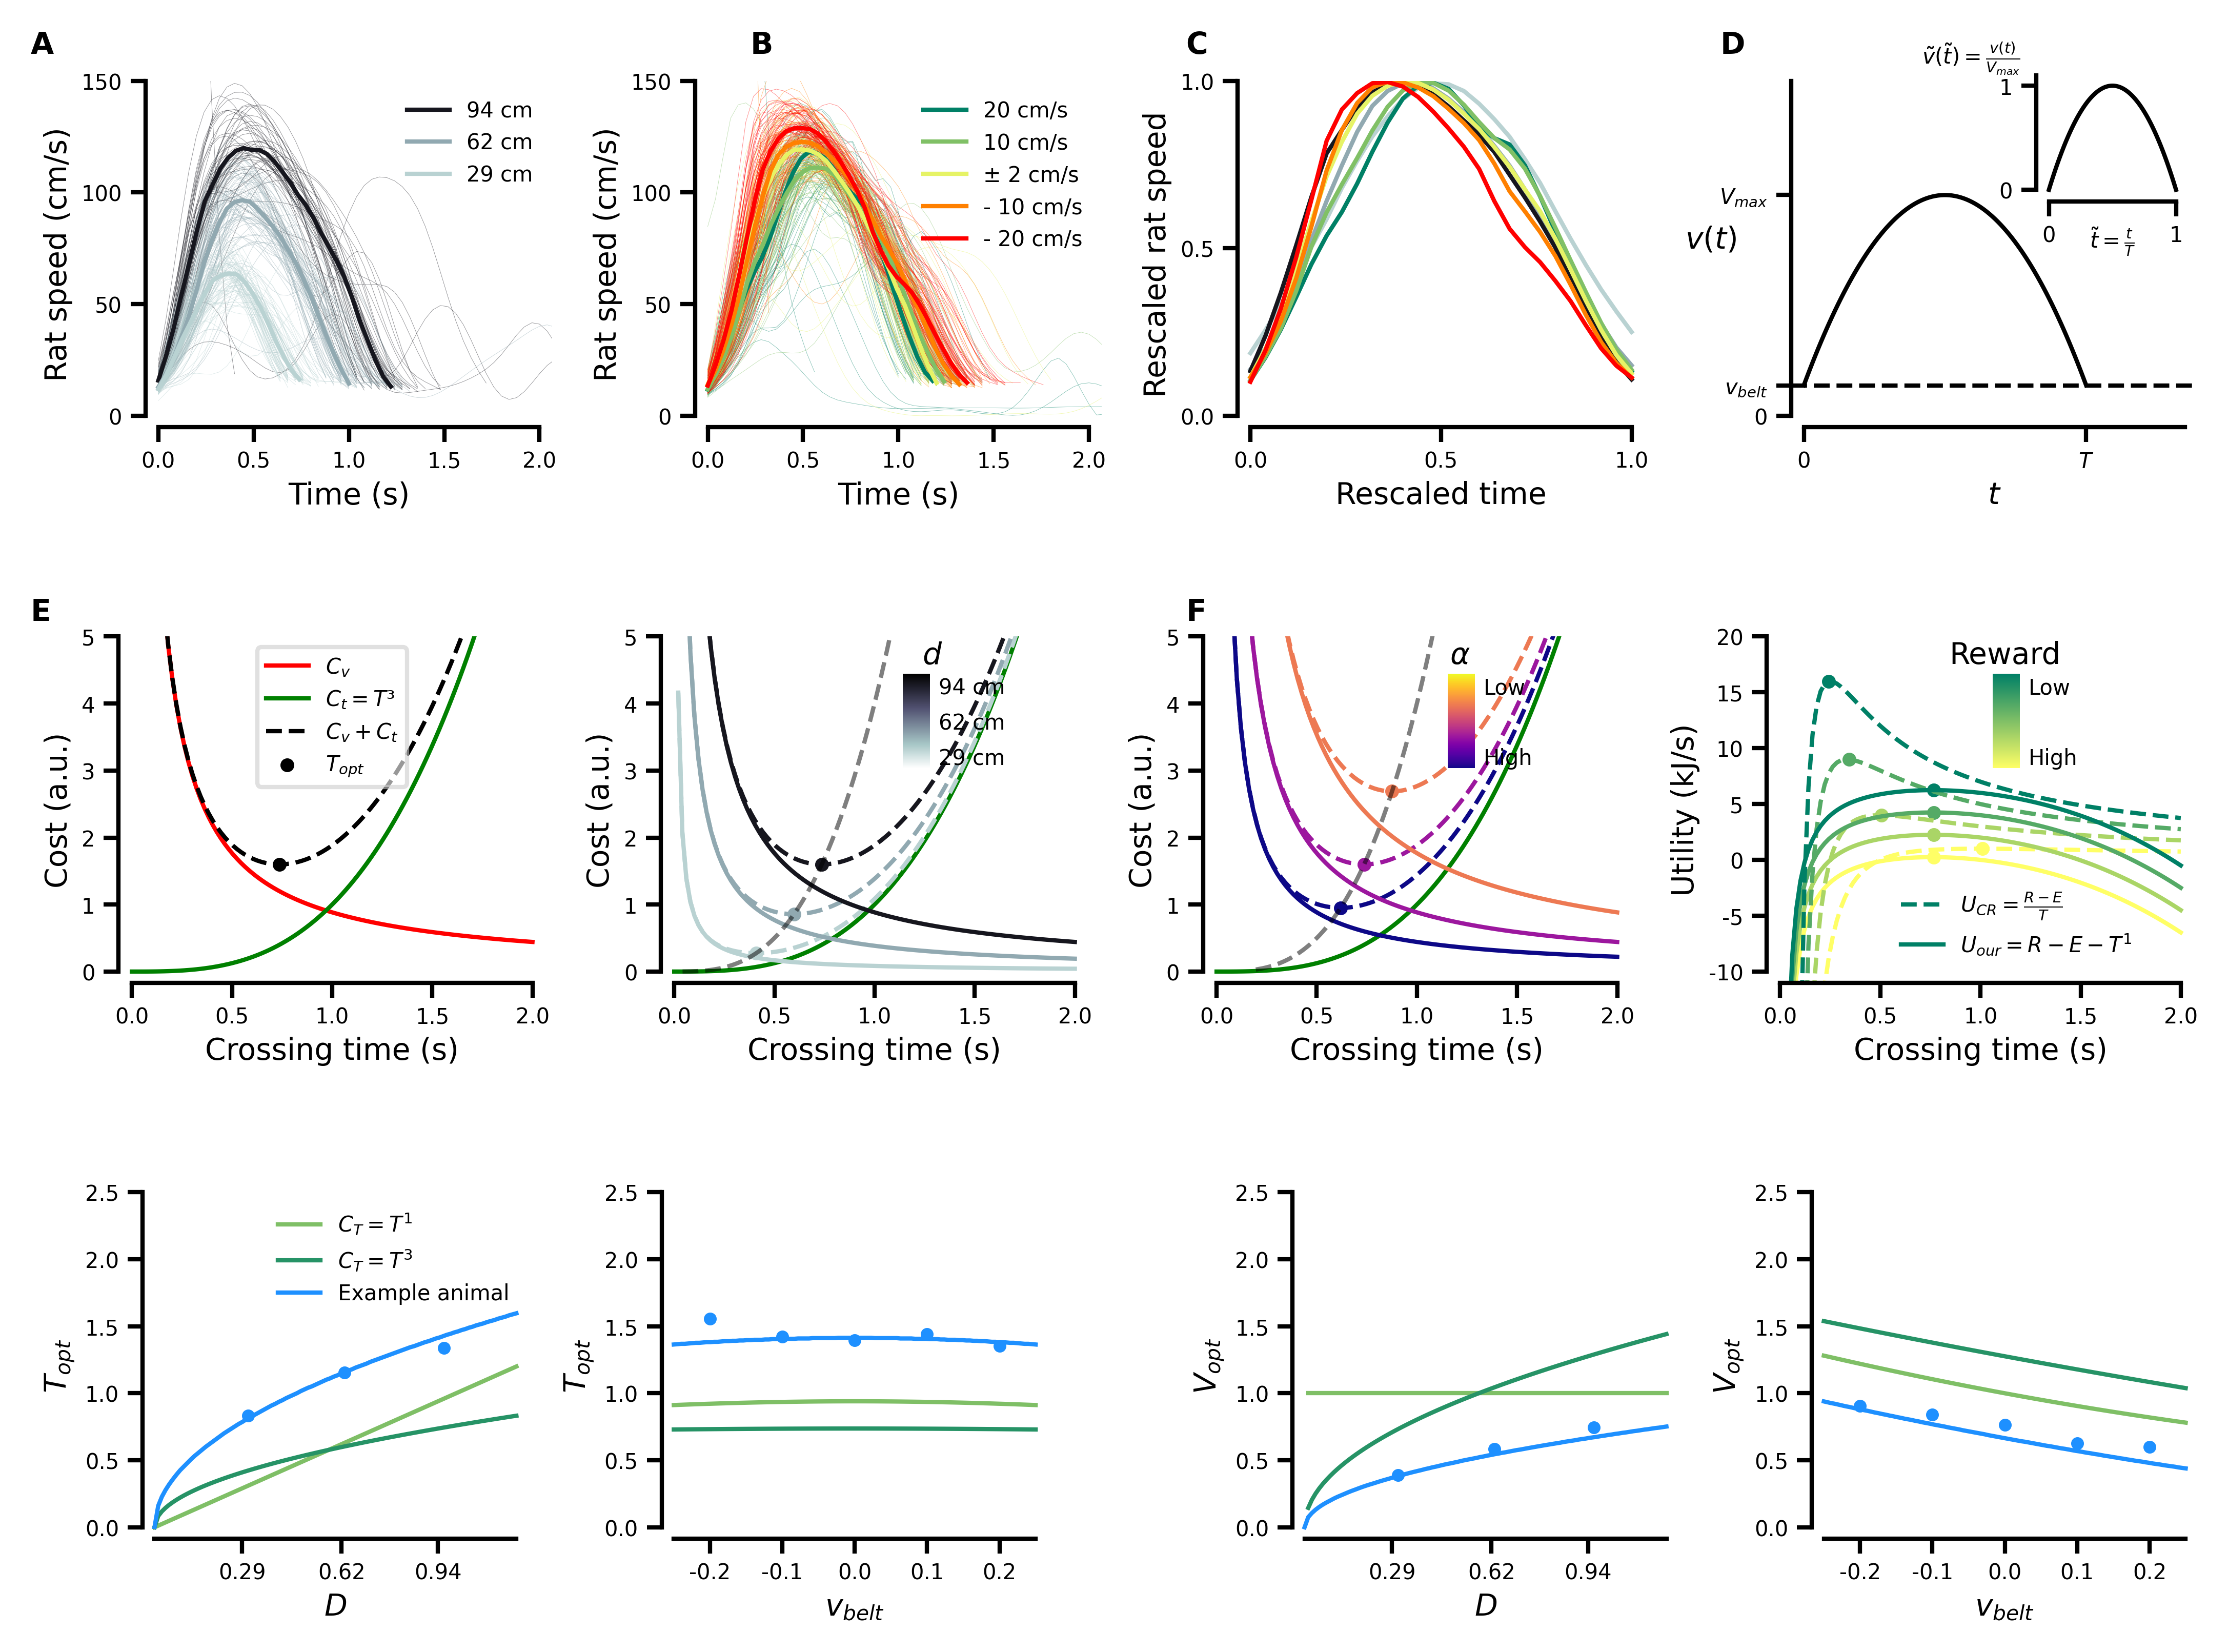

In [108]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=600, constrained_layout=True, facecolor='w')

gs0 = fig.add_gridspec(5, 1 , hspace=0.5, height_ratios=[5, 1, 5, 1, 5])

row1 = gs0[0].subgridspec(1, 4, width_ratios=[2, 2, 2, 2])
ax_raw_dist = plt.subplot(row1[0, 0])
ax_raw_vbelt = plt.subplot(row1[0, 1])
ax_rawrescaled = plt.subplot(row1[0, 2])
ax_notation = plt.subplot(row1[0, 3])


row2 = gs0[2].subgridspec(1, 4, width_ratios=[5, 5, 5, 5])
ax_model = plt.subplot(row2[0, 0])
ax_dist_effect = plt.subplot(row2[0, 1])
ax_alpha_effect = plt.subplot(row2[0, 2])
ax_reward_effect = plt.subplot(row2[0, 3])


row3 = gs0[4].subgridspec(1, 5, width_ratios=[5, 5, 1, 5, 5])
our_model_Topt_D = plt.subplot(row3[0, 0])
our_model_Topt_vbelt = plt.subplot(row3[0, 1])
our_model_Vopt_D = plt.subplot(row3[0, 3])
our_model_Vopt_vbelt = plt.subplot(row3[0, 4])


figuresLabels={"A":[0.00, 1.00], "B":[0.33, 1.00], "C":[0.53, 1.00], "D":[0.775, 1.00],
               "E":[0.00, 0.64], "F":[0.53, 0.64],}

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1], label, figure=fig, 
            weight='bold', fontsize=7, ha='left', va='bottom')


Figure3A(ax_raw_dist)
Figure3Abis(ax_raw_vbelt)
Figure3B(ax_rawrescaled)
Figure3C(ax_notation)

Figure3E_(ax_model)
Figure3D(ax_reward_effect)
Figure3G_(ax_dist_effect)
Figure3H_(ax_alpha_effect)

Figure3E(our_model_Topt_D)
Figure3F(our_model_Topt_vbelt)
Figure3I(our_model_Vopt_D)
Figure3J(our_model_Vopt_vbelt)


lC, bC, hC, wC = 0.92, .91, 0.08, 0.07
ax1 = fig.add_axes([lC, bC, wC, hC])
Figure3Cbis(ax=ax1)


h, w = 0.06, 0.0125
cbarD = fig.add_axes([.9, .55, w, h])
plot_colorbar(ax=cbarD, label='Reward', cmap='summer_r')

cbarG = fig.add_axes([.4, .55, w, h])
plot_colorbar(ax=cbarG, label=r'$d$', cmap='bone_r', labels=['29 cm', '62 cm', '94 cm'], show_zero=[200, False])

cbarH = fig.add_axes([.65, .55, w, h])
plot_colorbar(ax=cbarH, label=r'$\alpha$', cmap='plasma')


plt.savefig("/home/david/Desktop/code/Figure_3_V2.pdf", facecolor='w', 
                edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)


# bonus

In [109]:
<

SyntaxError: invalid syntax (4056019114.py, line 1)

In [ ]:
# def effort_cost(T, D=1, alpha=1, vbelt=0):
#     return alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T)

def effort_cost(T, D=1, alpha=1, vbelt=0, power_effort=1):
    vmax = (D - vbelt * T) / (T)
    return alpha * T * (vmax ** power_effort)

def time_cost(T, beta=1, power_time=1):
    return beta*T ** power_time


def plot_model(D=.94, vbelt=0, alpha=14.63, beta=1, power_effort=2.17, power_time=3.11):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    T = np.linspace(0.1, 2.5, 100)
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort), label='effort')
    # ax.plot(T, effort_cost2(T, D, alpha, vbelt, power), label='effort2', c='r')
    ax.plot(T, time_cost(T, beta, power_time), label='time')
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time), label='total')
    # argmin of total cost
    ax.plot(T[np.argmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))], 
            np.min(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time)),
            'o', color='k', label='approx min')

    print(f'argmin: {T[np.argmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))]}')
    # # total derivative
    # dydx = np.diff(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power))/np.diff(T)
    # ax.plot(T[:-1], dydx, label='total derivative', color='k', linestyle='--', alpha=0.5)

    # ax. axvline(T[np.argmin(effort_cost(T, D, alpha, vbelt) + time_cost(T, beta, power))],
    #             linestyle='--', color='k', alpha=0.5)

    ax.set_xlabel('T')
    ax.set_ylabel('cost')
    ax.legend()
    ax.set_title('Cost of a single trial')
    ax.set_ylim(0, 20)


interactive_plot = interactive(plot_model, D=(0, 2, .1), vbelt=(-.2, .2, 0.01), 
alpha=(0, 50.0, 0.5), beta=(0, 5, 0.5), 
power_effort=(0, 5, 0.1), power_time=(0, 5, 0.1))
interactive_plot

interactive(children=(FloatSlider(value=0.94, description='D', max=2.0), FloatSlider(value=0.0, description='v…

In [ ]:
# def ___(alpha=14.39, power_effort=2.11, power_time=3.08):
# def ___(alpha=14.34, power_effort=1.93, power_time=3.16):#only dist
# def ___(alpha=14.58, power_effort=2.74, power_time=3.1):#only tm
def ___(alpha=14.63, power_effort=2.17, power_time=3.11):#all
    fig, axs = plt.subplots(2,  2, figsize=(3, 3))

    def T_opt_n__(D, vbelt, alpha, power_effort, power_time):
        T = np.linspace(0.0, 2.5, 100)
        vmax = (D - vbelt * T) / (T)
        cost = alpha * T * vmax ** power_effort + T**power_time
        Topt = T[np.nanargmin(cost)]
        return Topt

    D_cst = .94
    Vbelt_cst = 0
    ALPHA = alpha

    D = np.linspace(0, 1, 100)
    VBELT = np.linspace(.25, -.25, 100)

    # Topt as a function of D
    axs[0,  0].plot(D, T_opt_n1(D, Vbelt_cst, ALPHA), label=f'E² + T¹')
    axs[0, 0].plot(D, T_opt_n3(D, Vbelt_cst, ALPHA), label=f'E² + T³')
    axs[0, 0].plot(D, [T_opt_n__(d, Vbelt_cst, ALPHA, power_effort=power_effort, power_time=power_time) for d in D], label=f'E^{power_effort:.2f} + T^{power_time:.2f}')
    axs[0, 0].legend()
    axs[0, 0].set_xlabel('D')
    axs[0, 0].set_ylabel(r'T_{opt}')
    axs[0, 0].set_ylim(0, 2.5)
    axs[0, 0].axvline(.3, color='k', alpha=0.5, linestyle='--')
    axs[0, 0].axvline(.63, color='k', alpha=0.5, linestyle='--')
    axs[0, 0].axvline(.95, color='k', alpha=0.5, linestyle='--')

    # Topt as a function of Vbelt
    axs[0, 1].plot(VBELT, T_opt_n1(D_cst, VBELT, ALPHA), label=f'E² + T¹')
    axs[0, 1].plot(VBELT, T_opt_n3(D_cst, VBELT, ALPHA), label=f'E² + T³')
    axs[0, 1].plot(VBELT, [T_opt_n__(D_cst, vbelt, ALPHA, power_effort=power_effort, power_time=power_time) for vbelt in VBELT], label=f'E^{power_effort:.2f} + T^{power_time:.2f}')

    axs[0, 1].legend()
    axs[0, 1].set_xlabel(r'v_{belt}')
    axs[0, 1].set_ylabel(r'T_{opt}')
    axs[0, 1].set_ylim(0, 2.5)

    print(f'D=0.3: {T_opt_n__(.3, 0, ALPHA, power_effort=power_effort, power_time=power_time):.2f}')
    print(f'D=0.63: {T_opt_n__(.63, 0, ALPHA, power_effort=power_effort, power_time=power_time):.2f}')
    print(f'D=0.95: {T_opt_n__(.95, 0, ALPHA, power_effort=power_effort, power_time=power_time):.2f}')
    print(f'Vbelt=0.2: {T_opt_n__(.95, .2, ALPHA, power_effort=power_effort, power_time=power_time):.2f}')
    print(f'Vbelt=0.1: {T_opt_n__(.95, 0.1, ALPHA, power_effort=power_effort, power_time=power_time):.2f}')
    print(f'Vbelt=0: {T_opt_n__(.95, 0, ALPHA, power_effort=power_effort, power_time=power_time):.2f}')
    print(f'Vbelt=-0.1: {T_opt_n__(.95, -.1, ALPHA, power_effort=power_effort, power_time=power_time):.2f}')
    print(f'Vbelt=-0.2: {T_opt_n__(.95, -.2, ALPHA, power_effort=power_effort, power_time=power_time):.2f}')


    axs[1,  0].plot(D, D/T_opt_n1(D, Vbelt_cst, ALPHA), label=f'E² + T¹')
    axs[1, 0].plot(D, D/T_opt_n3(D, Vbelt_cst, ALPHA), label=f'E² + T³')
    axs[1, 0].plot(D, D/[T_opt_n__(d, Vbelt_cst, ALPHA, power_effort=power_effort, power_time=power_time) for d in D], label=f'E^{power_effort:.2f} + T^{power_time:.2f}')
    axs[1, 0].legend()
    axs[1, 0].set_xlabel('D')
    axs[1, 0].set_ylabel(r'V_{opt}')
    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].axvline(.3, color='k', alpha=0.5, linestyle='--')
    axs[1, 0].axvline(.63, color='k', alpha=0.5, linestyle='--')
    axs[1, 0].axvline(.95, color='k', alpha=0.5, linestyle='--')

    # Topt as a function of Vbelt
    axs[1, 1].plot(VBELT, D_cst/T_opt_n1(D_cst, VBELT, ALPHA) - VBELT, label=f'E² + T¹')
    axs[1, 1].plot(VBELT, D_cst / T_opt_n3(D_cst, VBELT, ALPHA) - VBELT, label=f'E² + T³')
    axs[1, 1].plot(VBELT, D_cst / np.array([T_opt_n__(D_cst, vbelt, ALPHA, 
    power_effort=power_effort, power_time=power_time) for vbelt in VBELT]) - VBELT, label=f'E^{power_effort:.2f} + T^{power_time:.2f}')

    axs[1, 1].legend()
    axs[1, 1].set_xlabel(r'v_{belt}')
    axs[1, 1].set_ylabel(r'V_{opt}')
    axs[1, 1].set_ylim(0, 1)

    print(f'D=0.3: {D_cst/T_opt_n__(.3, 0, ALPHA, power_effort=power_effort, power_time=power_time) - 0:.2f}')
    print(f'D=0.63: {D_cst/T_opt_n__(.63, 0, ALPHA, power_effort=power_effort, power_time=power_time) - 0:.2f}')
    print(f'D=0.95: {D_cst/T_opt_n__(.95, 0, ALPHA, power_effort=power_effort, power_time=power_time) - 0:.2f}')
    print(f'Vbelt=0.2: {D_cst/T_opt_n__(.95, .2, ALPHA, power_effort=power_effort, power_time=power_time) - .2:.2f}')
    print(f'Vbelt=0.1: {D_cst/T_opt_n__(.95, 0.1, ALPHA, power_effort=power_effort, power_time=power_time) - .1:.2f}')
    print(f'Vbelt=0: {D_cst/T_opt_n__(.95, 0, ALPHA, power_effort=power_effort, power_time=power_time) - 0:.2f}')
    print(f'Vbelt=-0.1: {D_cst/T_opt_n__(.95, -.1, ALPHA, power_effort=power_effort, power_time=power_time) + .1:.2f}')
    print(f'Vbelt=-0.2: {D_cst/T_opt_n__(.95, -.2, ALPHA, power_effort=power_effort, power_time=power_time) + .2:.2f}')
    
interactive_plot = interactive(___, alpha=(0, 20, .1), power_effort=(0, 5, 0.05), power_time=(0, 5, 0.05))
interactive_plot

interactive(children=(FloatSlider(value=14.63, description='alpha', max=20.0), FloatSlider(value=2.17, descrip…

In [ ]:
run_times = {'60': 0.8631369403784583,
                '90': 1.1631603537559874,
                '120': 1.3790748543858773,
                '20': 1.3332268175993607,
                '10': 1.3625993067359892,
                '2': 1.397288119449051,
                'rev10': 1.4547904940201266,
                'rev20': 1.5524602934237337}

run_speeds = {'60': 30.732825789585366,
                '90': 47.77805051186509,
                '120': 61.12894287555996,
                '20': 46.91023945587427,
                '10': 54.65630557878278,
                '2': 59.55657941505085,
                'rev10': 70.45923566097731,
                'rev20': 78.50439753165827}

In [ ]:
conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

for cond in conds:
    print(cond, run_times[cond], run_speeds[cond], run_times[cond]*run_speeds[cond])

def T_opt_n__(D, vbelt, alpha, power_effort, power_time):
    T = np.linspace(0, 2.5, 75)
    vmax = (D - vbelt * T) / (T)
    cost = alpha * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt
    
def fit_func(args):
    alpha, power_time, power_effort = args
    S, M, L = .2915, .6217, .9445
    loss_60 = (T_opt_n__(S, 0, alpha=alpha, power_effort=power_effort, power_time=power_time) - run_times["60"])**2
    loss_90 = (T_opt_n__(M, 0, alpha=alpha, power_effort=power_effort, power_time=power_time) - run_times["90"])**2
    loss_120 = (T_opt_n__(L, 0, alpha=alpha, power_effort=power_effort, power_time=power_time) - run_times["120"])**2

    loss_20 = (T_opt_n__(L, .2, alpha=alpha, power_effort=power_effort, power_time=power_time) - run_times["20"])**2
    loss_10 = (T_opt_n__(L, .1, alpha=alpha, power_effort=power_effort, power_time=power_time) - run_times["10"])**2
    loss_2 = (T_opt_n__(L, .02, alpha=alpha, power_effort=power_effort, power_time=power_time) - run_times["2"])**2
    loss_rev10 = (T_opt_n__(L, -.1, alpha=alpha, power_effort=power_effort, power_time=power_time) - run_times["rev10"])**2
    loss_rev20 = (T_opt_n__(L, -.2, alpha=alpha, power_effort=power_effort, power_time=power_time) - run_times["rev20"])**2

    loss = loss_60 + loss_90 + loss_120 + loss_20 + loss_10 + loss_2 + loss_rev10 + loss_rev20
    return loss


from scipy.optimize import minimize
res = minimize(fit_func, [15, 3, 2], method='nelder-mead', options={'xatol': 1e-8})
print(res.x)

60 0.8631369403784583 30.732825789585366 26.52663722120689
90 1.1631603537559874 47.77805051186509 55.57353413515243
120 1.3790748543858773 61.12894287555996 84.30138799487545
20 1.3332268175993607 46.91023945587427 62.541989262579214
10 1.3625993067359892 54.65630557878278 74.47464409039979
2 1.397288119449051 59.55657941505085 83.21770085167446
rev10 1.4547904940201266 70.45923566097731 102.5034262555137
rev20 1.5524602934237337 78.50439753165827 121.87496002705163
[13.19444444  3.20185185  2.19012346]


In [ ]:
realdist60 = {}
realdist90 = {}
realdist120= {}
realdist20= {}
realdistrev20= {}

# compute the running distance for each run (pos start - pos end) for each distance configuration
for animal in animalList:
    realdist60[animal], realdist90[animal], realdist120[animal] = ([] for _ in range(3))
    realdist20[animal], realdistrev20[animal] = ([] for _ in range(2))
    for session in sorted(matchsession(animal, dist60)):
        for i in range(0, 12):
            realdist60[animal] = np.append(realdist60[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist60[animal] = np.append(realdist60[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist90)):   
        for i in range(0, 12):
            realdist90[animal] = np.append(realdist90[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist90[animal] = np.append(realdist90[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist120)):
        for i in range(0, 12):
            realdist120[animal] = np.append(realdist120[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist120[animal] = np.append(realdist120[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])

    for session in sorted(matchsession(animal, TM20)):
        for i in range(0, 12):
            realdist20[animal] = np.append(realdist20[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist20[animal] = np.append(realdist20[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, TMrev20)):
        for i in range(0, 12):
            realdistrev20[animal] = np.append(realdistrev20[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdistrev20[animal] = np.append(realdistrev20[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])



# compute the mean running distance for each animal for each distance configuration
medianrealdist60 = {}
medianrealdist90 = {}
medianrealdist120 = {}
medianrealdist20 = {}
medianrealdistrev20 = {}

for animal in animalList:
    medianrealdist60[animal] = np.median(realdist60[animal])
    medianrealdist90[animal] = np.median(realdist90[animal])
    medianrealdist120[animal] = np.median(realdist120[animal])
    medianrealdist20[animal] = np.median(realdist20[animal])
    medianrealdistrev20[animal] = np.median(realdistrev20[animal])

# compute the mean running distance for each distance configuration
medianrealdist60 = np.median([medianrealdist60[animal] for animal in animalList])
medianrealdist90 = np.median([medianrealdist90[animal] for animal in animalList])
medianrealdist120 = np.median([medianrealdist120[animal] for animal in animalList])
medianrealdist20 = np.median([medianrealdist20[animal] for animal in animalList])
medianrealdistrev20 = np.median([medianrealdistrev20[animal] for animal in animalList])

print('mean real distance for 60cm: ', medianrealdist60)
print('mean real distance for 90cm: ', medianrealdist90)
print('mean real distance for 120cm: ', medianrealdist120)
# print('mean real distance for TM 20: ', meanrealdist20)
# print('mean real distance for TM -20: ', meanrealdistrev20)

mean real distance for 60cm:  29.04442439927616
mean real distance for 90cm:  63.27253497258353
mean real distance for 120cm:  94.88418782239236


(0.0, 10.0)

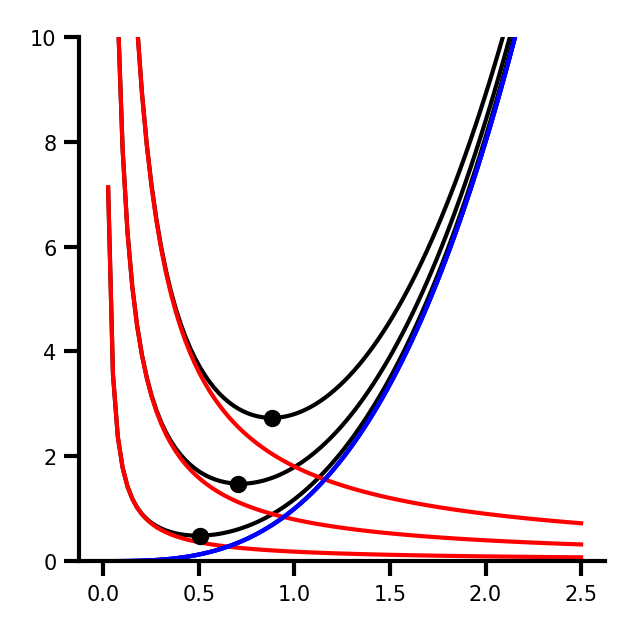

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
D = 1
alpha=2
beta= 1
x = np.linspace(-.2, .2, 100)
T = np.linspace(0., 2.5, 100)
power_time =3
power_effort = 2
for D in [.3, .63, .95]:
    C = effort_cost(T, D, alpha, 0, power_effort=power_effort) + time_cost(T, beta, power_time)
    ax.scatter(T[np.nanargmin(C)], np.nanmin(C), color='k', s=10, zorder=10)
    ax.plot(T, C, c= 'k')
    ax.plot(T, effort_cost(T, D, alpha, 0, power_effort=power_effort), c='r')
    ax.plot(T, time_cost(T, beta, power_time), c='b')

ax.set_ylim(0, 10)

(0.0, 10.0)

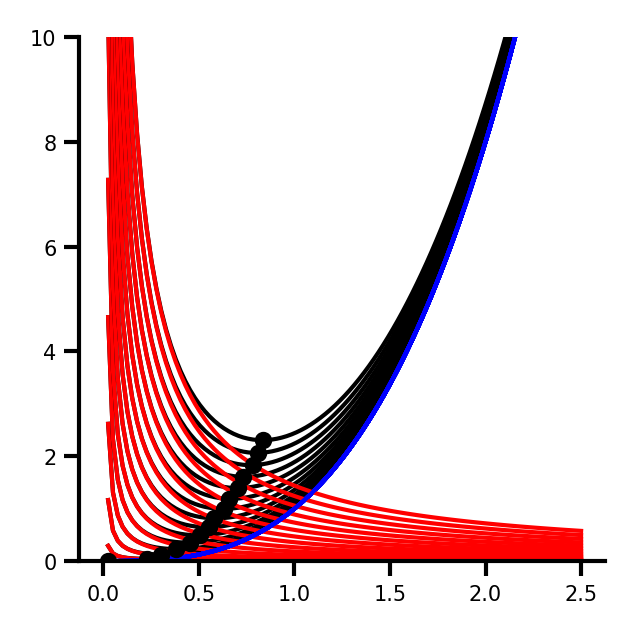

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
D = 1
alpha=1
beta= 1
x = np.linspace(-.2, .2, 100)
T = np.linspace(0., 2.5, 100)
power_time =3
power_effort = 2
for D in np.linspace(0, 1.2, 15):
    C = effort_cost(T, D, alpha, 0, power_effort=power_effort) + time_cost(T, beta, power_time)
    ax.scatter(T[np.nanargmin(C)], np.nanmin(C), color='k', s=10, zorder=10)
    ax.plot(T, C, c= 'k')
    ax.plot(T, effort_cost(T, D, alpha, 0, power_effort=power_effort), c='r')
    ax.plot(T, time_cost(T, beta, power_time), c='b')

ax.set_ylim(0, 10)

(0.0, 10.0)

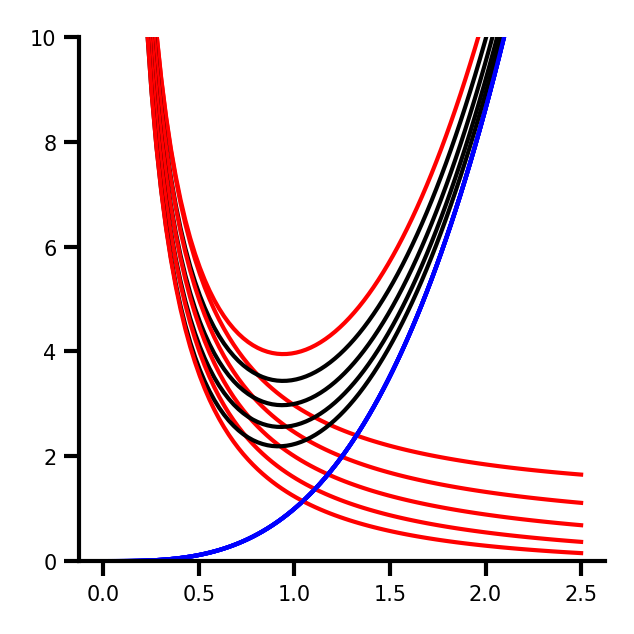

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

D = 1
alpha=2
beta= 1
x = np.linspace(-.2, .2, 100)
T = np.linspace(0., 2.5, 100)
power_time =3.11
power_effort = 2.17
for vbelt in [-.2, -.1, 0, .1, .2]:
    C = [effort_cost(T, D, alpha, vbelt, power_effort=power_effort) + time_cost(T, beta, power_time)]
    ax.scatter(T[np.argmin(C[0])], np.min(C[0]), color='k', s=10, zorder=10)
    ax.plot(T, C[0], label=f'vbelt={vbelt}', c='r' if vbelt==-.2 else 'k')

    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort=power_effort), label=f'vbelt={vbelt}', c='r')

    ax.plot(T, time_cost(T, beta, power_time), label=f'vbelt={vbelt}', c='b')

# ax.plot(x, Topt)

ax.set_ylim(0, 10)